In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '1'
ROOT = ENV['PWD']

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import scipy
from scipy.special import expit as sigmoid

# import jax
# import jax.numpy as jnp

import numpy as np
import numpy.typing as npt

Float = np.float64

# print(jax.devices())
# jax.config.update("jax_enable_x64", True)

# import pennylane as qml
# dev_gpu = qml.device("lightning.qubit", wires=18)  # GPU not that much slower, helps with indexing ig?
# dev_cpu = qml.device("lightning.qubit", wires=4)  # CPU faster for 4 qubits

In [2]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

# data loading

In [3]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons] # .apply(lambda x: rescale(x, np.pi/2), axis=1)
coords = get_coords(record).loc[sig_neurons]

In [4]:
corrs_df = tuning_curves.T.corr()

In [5]:
corrs_df

,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
23,1.000000,-0.489674,0.661540,0.206720,0.604894,0.738459,0.840655,0.842762,0.819609,0.420833,...,0.597267,0.295981,0.410455,0.185429,0.693904,0.720026,0.825029,0.455308,0.632510,0.308969
32,-0.489674,1.000000,-0.596449,0.086894,0.181528,-0.048669,-0.353843,-0.170236,-0.154536,-0.066270,...,0.215513,0.266487,0.337279,0.143623,-0.130767,-0.093222,-0.280509,0.035892,-0.390656,0.068023
35,0.661540,-0.596449,1.000000,0.036591,0.253894,0.699936,0.753505,0.719987,0.710097,0.525593,...,0.190534,0.284538,0.420381,0.136743,0.529959,0.492206,0.831712,0.002947,0.405079,0.171913
36,0.206720,0.086894,0.036591,1.000000,0.182721,0.057567,0.386210,0.156337,0.045494,0.075295,...,0.109216,0.202316,0.410737,0.039800,-0.179925,0.310371,0.169477,0.044842,-0.231750,0.446474
37,0.604894,0.181528,0.253894,0.182721,1.000000,0.775998,0.728235,0.696522,0.823081,0.659072,...,0.733332,0.756497,0.570538,0.392736,0.773308,0.599689,0.639477,0.604168,0.536870,0.714616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.720026,-0.093222,0.492206,0.310371,0.599689,0.806530,0.655613,0.837230,0.692688,0.194146,...,0.761772,0.116137,0.358099,-0.163071,0.483677,1.000000,0.629357,0.777114,0.077318,0.307842
425,0.825029,-0.280509,0.831712,0.169477,0.639477,0.884600,0.892171,0.853809,0.942081,0.748289,...,0.582319,0.614619,0.717722,0.333818,0.754016,0.629357,1.000000,0.190794,0.596609,0.471784
426,0.455308,0.035892,0.002947,0.044842,0.604168,0.510365,0.327662,0.500403,0.410597,0.003023,...,0.680641,-0.034927,-0.094314,-0.229323,0.349806,0.777114,0.190794,1.000000,0.039779,0.304123
428,0.632510,-0.390656,0.405079,-0.231750,0.536870,0.403937,0.521279,0.387531,0.652936,0.561446,...,0.372136,0.521788,0.283315,0.315866,0.825566,0.077318,0.596609,0.039779,1.000000,0.318983


In [6]:
corrs_df.to_csv(ENV['PWD'] + '/data/classical-correlations.csv')


In [7]:
# invert fidelities as a fidelity of 1 = "same" and 0 = "different"
quantum_fidelity_matrix_ang = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed.csv', index_col=0)
quantum_fidelity_matrix_ang_qft = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed_qft.csv', index_col=0)
quantum_fidelity_matrix_amp = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed.csv', index_col=0)
quantum_fidelity_matrix_amp_qft = 1-pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed_qft.csv', index_col=0)


In [8]:
# load and reconstruct the distance matrices from the qpus
qpu_results_df = pd.read_excel(ENV['PWD'] + '/data/quantum_fidelity_ibm_kingston.xlsx', index_col=0)


In [9]:
# make fully symmetric matrix
for i in range(len(qpu_results_df)):
    row = qpu_results_df.loc[i]
    if row['A'] != row['B']:
        new_row = row.copy()
        new_row['B'] = row['A']
        new_row['A'] = row['B']
        qpu_results_df.loc[len(qpu_results_df)] = new_row

In [10]:
qpu_results_df


,A,B,ang,amp_qft,amp_qft_ddd,amp,amp_ddd
0,23.0,32.0,0.501373,0.360,0.356,0.565,0.620
1,23.0,35.0,0.501587,0.685,0.661,0.776,0.774
2,23.0,36.0,0.501564,0.578,0.550,0.709,0.685
3,23.0,37.0,0.501579,0.648,0.602,0.763,0.758
4,23.0,50.0,0.501617,0.656,0.696,0.756,0.771
...,...,...,...,...,...,...,...
5771,428.0,425.0,0.501560,0.667,0.672,0.777,0.734
5772,435.0,425.0,0.501560,0.655,0.628,0.779,0.784
5773,428.0,426.0,0.501633,0.617,0.610,0.811,0.793
5774,435.0,426.0,0.501621,0.680,0.684,0.786,0.788


In [11]:
# turn into symmetric matrices
qpu_ang, qpu_amp_qft, qpu_amp_qft_ddd, qpu_amp, qpu_amd_ddd = [1-qpu_results_df.pivot_table(index = 'A', columns = 'B')[col].astype(np.float64) for col in ['ang', 'amp_qft', 'amp_qft_ddd', 'amp', 'amp_ddd']]

In [12]:
rescaled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/rescaled_tuning_curves.csv', index_col=0)
rescaled_tuning_curves

,3.0,4.2,6.0,8.5,12.0,17.0,24.0,33.9,48.0
23,0.272445,0.226280,0.528095,0.342139,0.478668,0.216327,0.388480,0.282726,0.406432
32,0.246955,0.251824,0.261320,0.301364,0.240421,0.677847,0.152107,0.650394,0.359361
35,0.329700,0.345059,0.396044,0.403043,0.472854,0.287826,0.304725,0.239381,0.362960
36,0.293999,0.259318,0.282788,0.360842,0.323867,0.329879,0.353300,0.333539,0.604061
37,0.239892,0.220883,0.447163,0.443715,0.374524,0.325597,0.328626,0.408209,0.352983
...,...,...,...,...,...,...,...,...,...
424,0.211562,0.142474,0.785516,0.386134,0.361296,0.342168,0.184937,0.168489,0.559018
425,0.306663,0.238587,0.426167,0.401231,0.506186,0.294095,0.299420,0.296495,0.372749
426,0.314137,0.290121,0.517580,0.374248,0.256840,0.341100,0.333903,0.349291,0.364372
428,0.307663,0.282272,0.377610,0.382645,0.434304,0.299115,0.426110,0.349712,0.282161


In [13]:
resampled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/resampled_tuning_curves.csv', index_col=0)
resampled_tuning_curves

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
23,0.049073,0.039918,0.042466,0.075074,0.094048,0.071611,0.064602,0.082698,0.077755,0.044527,0.046081,0.068616,0.063313,0.051262,0.055749,0.073207
32,0.043356,0.043741,0.044285,0.045031,0.046348,0.050228,0.052905,0.044969,0.052667,0.108142,0.099962,0.031631,0.052624,0.111210,0.109811,0.063090
35,0.059220,0.060157,0.062332,0.067351,0.071698,0.071929,0.074087,0.082499,0.080567,0.056549,0.052081,0.055091,0.050466,0.043463,0.047315,0.065194
36,0.054015,0.049772,0.047671,0.049213,0.053367,0.062580,0.065870,0.061018,0.059588,0.060128,0.061826,0.064329,0.064520,0.061341,0.073780,0.110982
37,0.042642,0.037452,0.040609,0.064365,0.080144,0.080781,0.076793,0.069766,0.063875,0.058910,0.057124,0.057708,0.063151,0.071911,0.072028,0.062744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.038788,0.022251,0.029875,0.101378,0.141131,0.094036,0.069800,0.067258,0.065521,0.064002,0.056276,0.037474,0.028246,0.029893,0.051580,0.102491
425,0.055056,0.044896,0.043907,0.063648,0.076840,0.072887,0.074830,0.087617,0.085388,0.057789,0.053026,0.053720,0.053528,0.053216,0.056730,0.066920
426,0.056335,0.050662,0.053334,0.078388,0.091691,0.077286,0.062515,0.048800,0.048563,0.059304,0.060755,0.059765,0.060875,0.062461,0.063923,0.065344
428,0.054627,0.050518,0.050672,0.060430,0.067494,0.067470,0.069372,0.075302,0.074053,0.056338,0.058207,0.074734,0.071477,0.062910,0.056297,0.050099


In [14]:
from scipy.fft import ifft
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

euclidean_distance = pd.DataFrame(columns = ['A', 'B', 'euclidean', 'euclidean_ifft'])

 # A x B
pairs, pairs_len = combinations(rescaled_tuning_curves.index, 2), (len(rescaled_tuning_curves) * (len(rescaled_tuning_curves) - 1) // 2)
for a, b in pairs:
    a_i, b_i = rescaled_tuning_curves.loc[a], rescaled_tuning_curves.loc[b]
    a_i_resampled, b_i_resampled = resampled_tuning_curves.loc[a], resampled_tuning_curves.loc[b]
    dist = euclidean(a_i, b_i)
    dist_ifft = euclidean(ifft(a_i_resampled), ifft(b_i_resampled))
    # print(dist)
    euclidean_distance.loc[len(euclidean_distance)] = [a, b, dist, dist_ifft]
    euclidean_distance.loc[len(euclidean_distance)] = [b, a, dist, dist_ifft]

# # A x A
# # for sanity checking
for a in rescaled_tuning_curves.index:
    a_i = rescaled_tuning_curves.loc[a]
    a_i_resampled = resampled_tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    dist_ifft = euclidean(ifft(a_i), ifft(a_i))
    euclidean_distance.loc[len(euclidean_distance)] = [a, a, dist, dist_ifft]


In [15]:
euclidean_distance_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean'].astype(np.float64)
euclidean_distance_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,0.732914,0.233373,0.376584,0.250854,0.210692,0.185061,0.172488,0.198512,0.282613,...,0.253264,0.314650,0.385392,0.383556,0.509887,0.431631,0.176818,0.284447,0.242550,0.302799
32.0,0.732914,0.000000,0.665136,0.578849,0.536400,0.595732,0.618616,0.652946,0.672797,0.558283,...,0.516963,0.512473,0.540280,0.565058,0.909246,0.834051,0.637110,0.560685,0.614181,0.542025
35.0,0.233373,0.665136,0.000000,0.341400,0.260809,0.179981,0.134466,0.211872,0.245494,0.173298,...,0.219627,0.234896,0.354210,0.327074,0.593495,0.529323,0.131582,0.285121,0.200582,0.231925
36.0,0.376584,0.578849,0.341400,0.000000,0.331815,0.369095,0.274211,0.383344,0.436164,0.312081,...,0.305188,0.312364,0.376256,0.398873,0.778080,0.577054,0.339235,0.345477,0.364013,0.258222
37.0,0.250854,0.536400,0.260809,0.331815,0.000000,0.161407,0.157469,0.218539,0.201740,0.171620,...,0.157216,0.151016,0.319231,0.289782,0.518039,0.495743,0.197658,0.194446,0.197849,0.159622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,0.431631,0.834051,0.529323,0.577054,0.495743,0.422691,0.496607,0.381511,0.437008,0.587213,...,0.498264,0.606985,0.584753,0.705332,0.649415,0.000000,0.484905,0.455995,0.608291,0.569163
425.0,0.176818,0.637110,0.131582,0.339235,0.197658,0.117708,0.110334,0.159658,0.143231,0.159956,...,0.192705,0.193559,0.273840,0.306849,0.519069,0.484905,0.000000,0.283242,0.192077,0.214668
426.0,0.284447,0.560685,0.285121,0.345477,0.194446,0.229199,0.227707,0.268582,0.319164,0.253846,...,0.151496,0.289709,0.457107,0.392432,0.631964,0.455995,0.283242,0.000000,0.261310,0.220057


In [16]:
euclidean_distance_df.to_csv(ENV['PWD'] + '/data/euclidean_distance.csv')

In [17]:
euclidean_distance_ifft_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean_ifft'].astype(np.float64)
euclidean_distance_ifft_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,0.036165,0.011961,0.018908,0.011727,0.009997,0.008651,0.008606,0.010152,0.013424,...,0.012241,0.015224,0.020853,0.020239,0.026659,0.022937,0.008888,0.013948,0.011987,0.014225
32.0,0.036165,0.000000,0.034554,0.027276,0.027198,0.031222,0.031032,0.033649,0.034725,0.028268,...,0.026048,0.025698,0.027351,0.027486,0.047385,0.044551,0.032327,0.029146,0.030465,0.027191
35.0,0.011961,0.034554,0.000000,0.018672,0.014777,0.009612,0.007975,0.011183,0.013411,0.009865,...,0.011966,0.013547,0.020425,0.019106,0.031099,0.027752,0.007421,0.015559,0.011190,0.013044
36.0,0.018908,0.027276,0.018672,0.000000,0.016459,0.019359,0.014211,0.020244,0.022731,0.015336,...,0.014883,0.015193,0.020287,0.019542,0.040068,0.032060,0.017629,0.017807,0.017649,0.012642
37.0,0.011727,0.027198,0.014777,0.016459,0.000000,0.009226,0.008190,0.011456,0.011004,0.009090,...,0.008714,0.008069,0.017651,0.015655,0.027509,0.026341,0.010627,0.010979,0.010645,0.007948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,0.022937,0.044551,0.027752,0.032060,0.026341,0.022154,0.026344,0.020029,0.022764,0.030910,...,0.027201,0.032109,0.032252,0.037720,0.032942,0.000000,0.025740,0.024745,0.032212,0.030192
425.0,0.008888,0.032327,0.007421,0.017629,0.010627,0.006133,0.005944,0.008412,0.007626,0.008214,...,0.010312,0.010045,0.015215,0.017271,0.026830,0.025740,0.000000,0.015588,0.010260,0.011097
426.0,0.013948,0.029146,0.015559,0.017807,0.010979,0.013041,0.012080,0.014270,0.017780,0.013830,...,0.008868,0.016036,0.025823,0.020994,0.033966,0.024745,0.015588,0.000000,0.013820,0.012003


# Cross-correlation btrw multiple matrices

/tmp/ipykernel_31005/1901347751.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


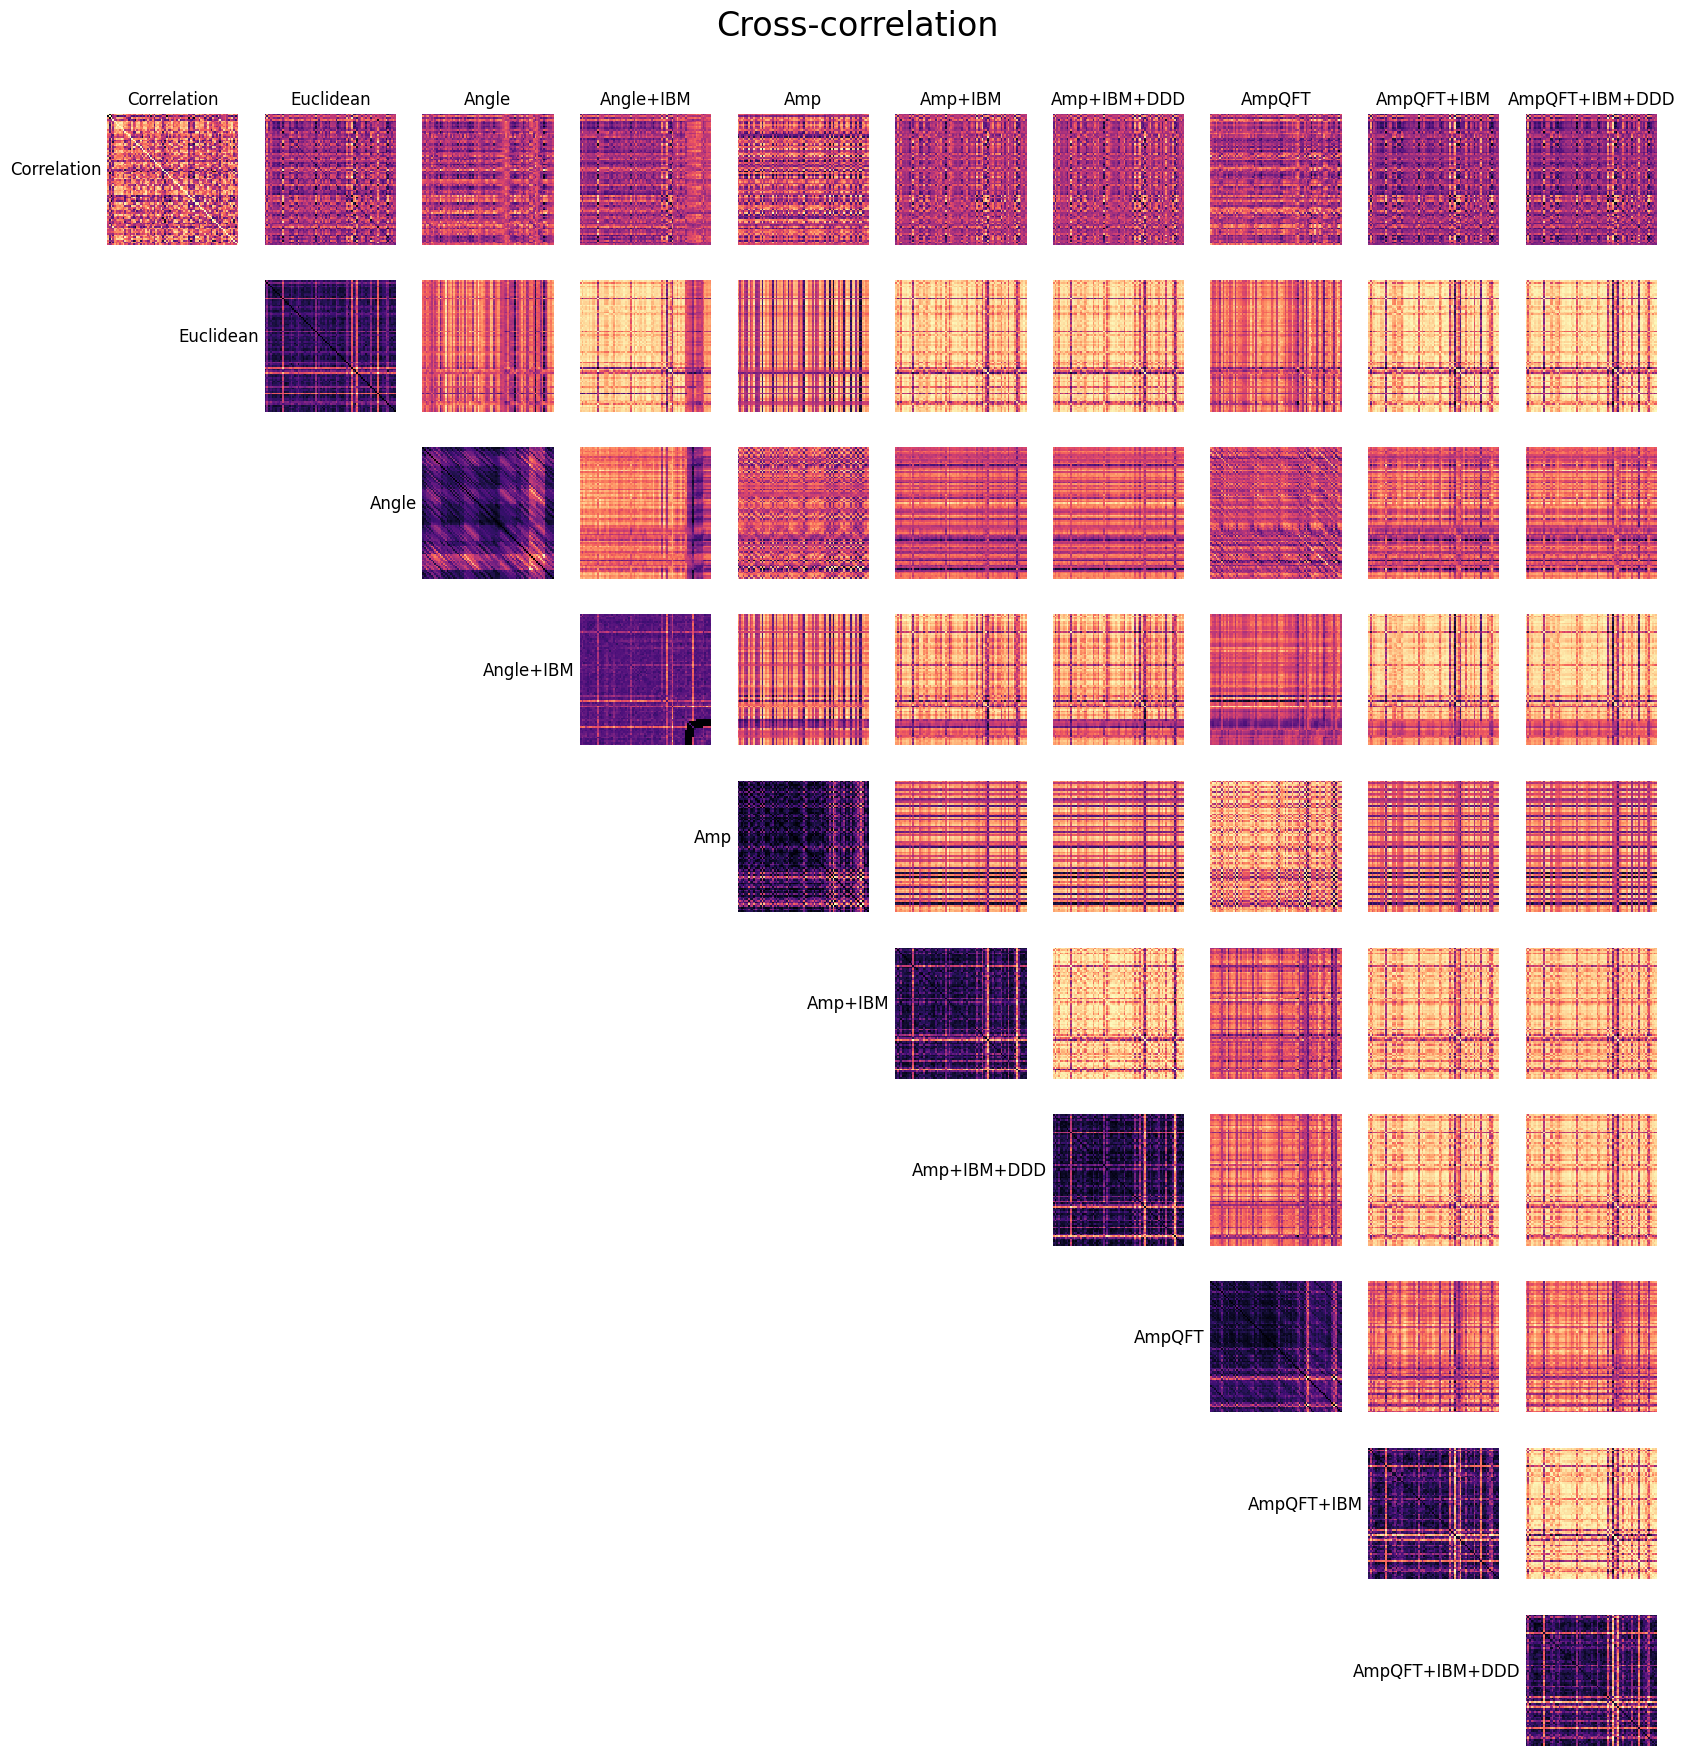

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create sample matrices
matrices = [
    corrs_df,
    euclidean_distance_df,
    # euclidean_distance_ifft_df, # basically the same
    quantum_fidelity_matrix_ang, qpu_ang,
    # quantum_fidelity_matrix_ang_qft, # basically the same
    quantum_fidelity_matrix_amp, qpu_amp, qpu_amd_ddd,
    quantum_fidelity_matrix_amp_qft, qpu_amp_qft, qpu_amp_qft_ddd
]
N = len(matrices)
titles = [
          'Correlation',
          'Euclidean',
          'Angle',
          'Angle+IBM',
          'Amp',
          'Amp+IBM',
          'Amp+IBM+DDD',
          'AmpQFT',
          'AmpQFT+IBM',
          'AmpQFT+IBM+DDD']

# Create a figure
fig = plt.figure(figsize=(N*2, N*2))

# Create a grid spec
gs = gridspec.GridSpec(N, N, wspace=0.2, hspace=0.2)

def replace_bottom_triangle_with_nan(matrix):
    new_matrix = matrix.copy()
    n = matrix.shape[0]
    mask = np.tril(np.ones((n, n), dtype=bool))
    new_matrix[mask] = None
    return new_matrix


# Plot original heatmaps on the main diagonal and correlation heatmaps
for i in range(N):
    for j in range(i, N):
        if i == j:
            # Plot original heatmaps on the main diagonal
            ax = fig.add_subplot(gs[i, j])
            upper_triangle_matrix = matrices[i]
            # upper_triangle_matrix = replace_bottom_triangle_with_nan(upper_triangle_matrix)  # to eliminate lower triangle
            sns.heatmap(upper_triangle_matrix, ax=ax, cbar=False, square=True, cmap='magma') #, vmin=0, vmax=1)

        elif i < j:
            # Plot correlation heatmaps in the upper triangle
            ax = fig.add_subplot(gs[i, j])
            corr = np.corrcoef(matrices[i], matrices[j])
            sns.heatmap(corr[:76, 76:], ax=ax, cbar=False, square=True, cmap='magma') #, vmin=0, vmax=1)

        # clear labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        if i == 0:
            ax.set_title(titles[j], fontsize=12)  # Set title for top row
        if i == j:
            ax.set_ylabel(titles[i], fontsize=12, rotation=0, ha='right')  # Set ylabel for left column

fig.suptitle('Cross-correlation', fontsize=24)
fig.subplots_adjust(top=0.93)  # move suptitle down
plt.tight_layout()

plt.savefig(ENV['PWD'] + '/figures/cross-correlation.png', dpi=300)
plt.show()


## heatmaps of main diagonal specifically

Just the main diagonal into 3 different plots for closer viewing


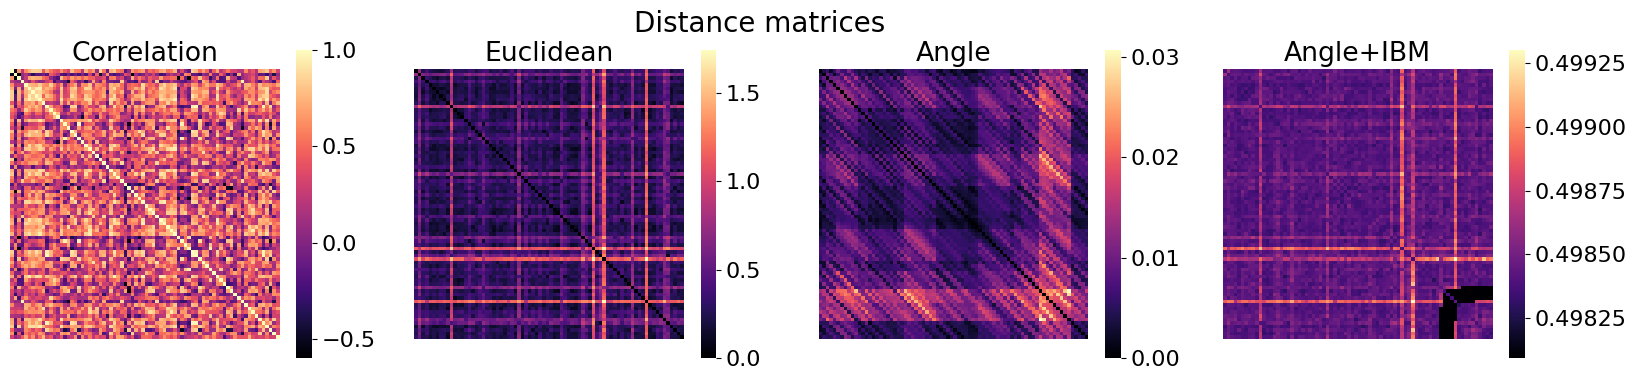

In [19]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Distance matrices', fontsize=20)
plt.savefig(ENV['PWD'] + '/figures/correlation-classical-and-ang.png', dpi=300)
plt.show()

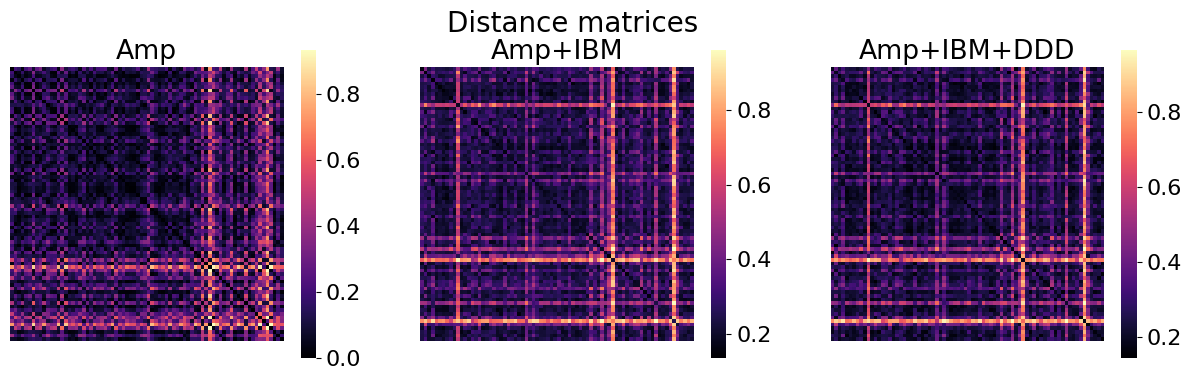

In [20]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for j in range(len(axes)):
    ax = axes[j]
    i = j+4
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Distance matrices', fontsize=20)
plt.savefig(ENV['PWD'] + '/figures/correlation-amp', dpi=300)
plt.show()

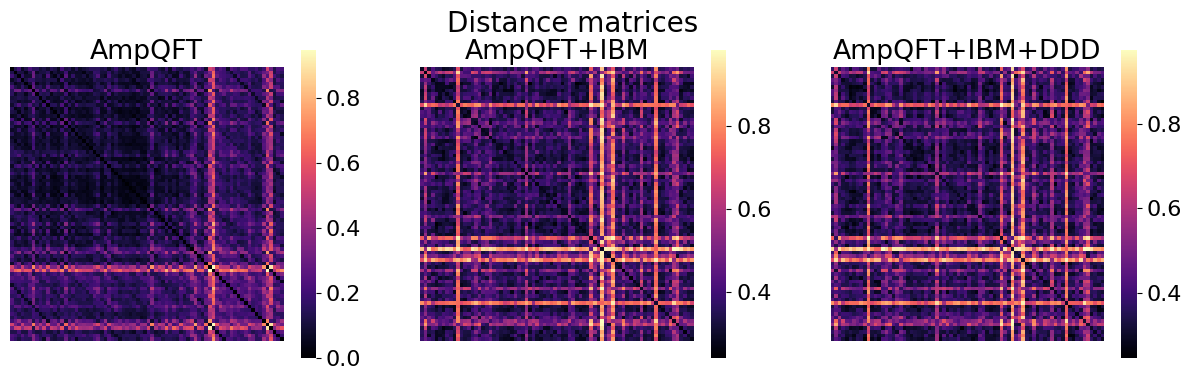

In [21]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for j in range(len(axes)):
    ax = axes[j]
    i = j+7
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Distance matrices', fontsize=20)

plt.savefig(ENV['PWD'] + '/figures/correlation-amp-qft', dpi=300)

plt.show()

# DO IT AGAIN but with vmin/vmax set
# Plot original heatmaps on the main diagonal and correlation heatmaps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create sample matrices
matrices = [
    euclidean_distance_df,
    # euclidean_distance_ifft_df, # basically the same
    quantum_fidelity_matrix_ang, qpu_ang,
    # quantum_fidelity_matrix_ang_qft, # basically the same
    quantum_fidelity_matrix_amp, qpu_amp, qpu_amd_ddd,
    quantum_fidelity_matrix_amp_qft, qpu_amp_qft, qpu_amp_qft_ddd
]
N = len(matrices)


# Create a figure
fig = plt.figure(figsize=(N*2, N*2))

# Create a grid spec
gs = gridspec.GridSpec(N, N, wspace=0.2, hspace=0.2)

def replace_bottom_triangle_with_nan(matrix):
    new_matrix = matrix.copy()
    n = matrix.shape[0]
    mask = np.tril(np.ones((n, n), dtype=bool))
    new_matrix[mask] = None
    return new_matrix


# Plot original heatmaps on the main diagonal and correlation heatmaps
for i in range(N):
    for j in range(i, N):
        if i == j:
            # Plot original heatmaps on the main diagonal
            ax = fig.add_subplot(gs[i, j])
            upper_triangle_matrix = matrices[i]
            # upper_triangle_matrix = replace_bottom_triangle_with_nan(upper_triangle_matrix)  # to eliminate lower triangle
            sns.heatmap(upper_triangle_matrix, ax=ax, cbar=False, square=True, cmap='magma', vmin=0, vmax=1)

        elif i < j:
            # Plot correlation heatmaps in the upper triangle
            ax = fig.add_subplot(gs[i, j])
            corr = np.corrcoef(matrices[i], matrices[j])
            sns.heatmap(corr[:76, 76:], ax=ax, cbar=False, square=True, cmap='magma', vmin=0, vmax=1)

        # clear labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        if i == 0:
            ax.set_title(titles[j], fontsize=12)  # Set title for top row
        if i == j:
            ax.set_ylabel(titles[i], fontsize=12, rotation=0, ha='right')  # Set ylabel for left column

fig.suptitle('Cross-correlation (raw)', fontsize=24)
fig.subplots_adjust(top=0.93)  # move suptitle down

plt.savefig(ENV['PWD'] + '/figures/cross-correlation-raw.png', dpi=300)
plt.show()

In [22]:
import seaborn as sns

Text(0.5, 1.0, 'Amp vs Amp+QFT')

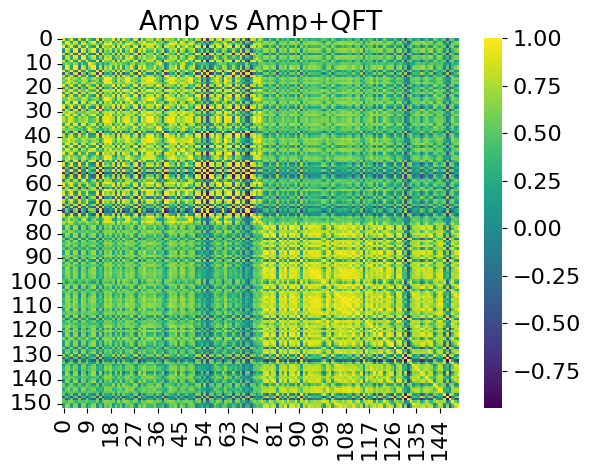

In [23]:
# QFT makes a difference for Amplitude Embedding
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp, quantum_fidelity_matrix_amp_qft), cmap='viridis')
plt.title('Amp vs Amp+QFT')

Text(0.5, 1.0, 'Angle vs Angle+QFT')

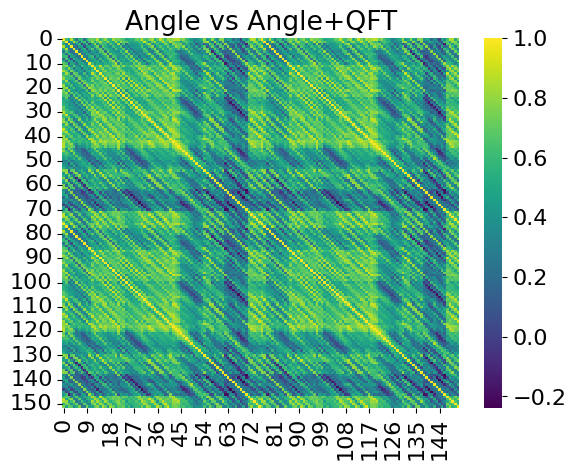

In [24]:
# Exactly the same for angle embedding
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_ang, quantum_fidelity_matrix_ang_qft), cmap='viridis')
plt.title('Angle vs Angle+QFT')

Text(0.5, 1.0, 'Amp vs Ang')

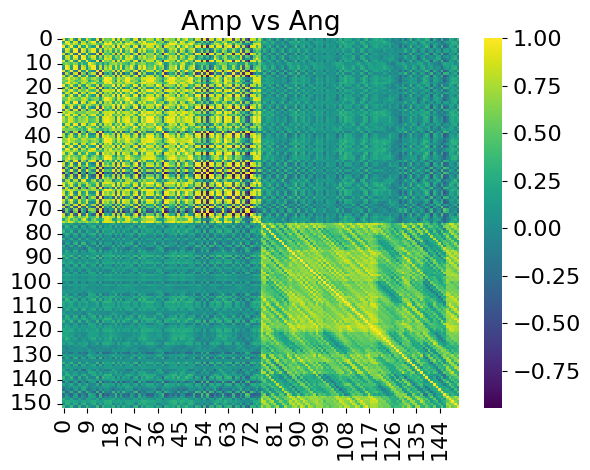

In [25]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp, quantum_fidelity_matrix_ang), cmap='viridis')
plt.title('Amp vs Ang')

Text(0.5, 1.0, 'Amp vs Ang QFT')

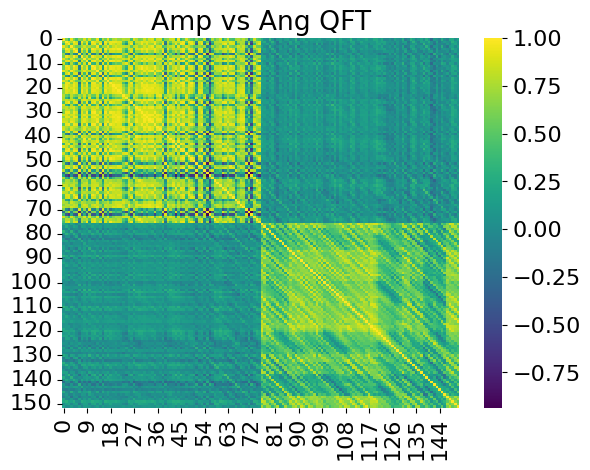

In [26]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp_qft, quantum_fidelity_matrix_ang), cmap='viridis')
plt.title('Amp vs Ang QFT')

Text(0.5, 1.0, 'Euclidean distance vs Euclidean distance after iFFT')

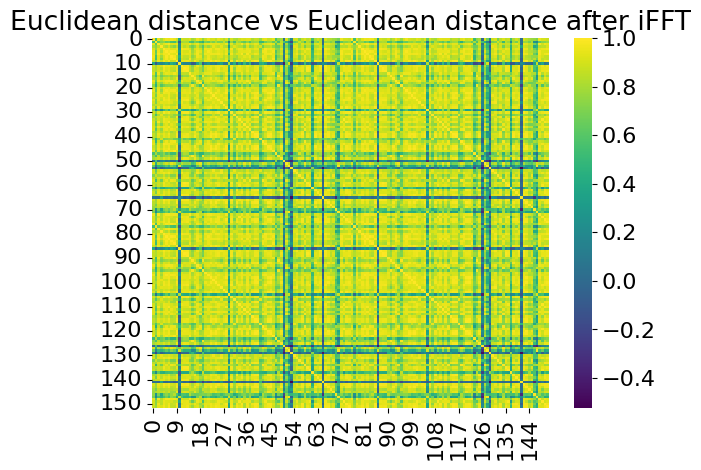

In [27]:
# exactly the same
sns.heatmap(np.corrcoef(euclidean_distance_df, euclidean_distance_ifft_df), cmap='viridis')
plt.title('Euclidean distance vs Euclidean distance after iFFT')

<Axes: >

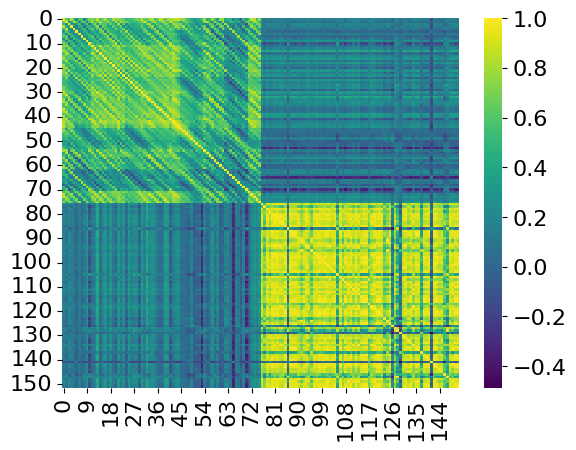

In [28]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_ang, euclidean_distance_df), cmap='viridis')

<Axes: >

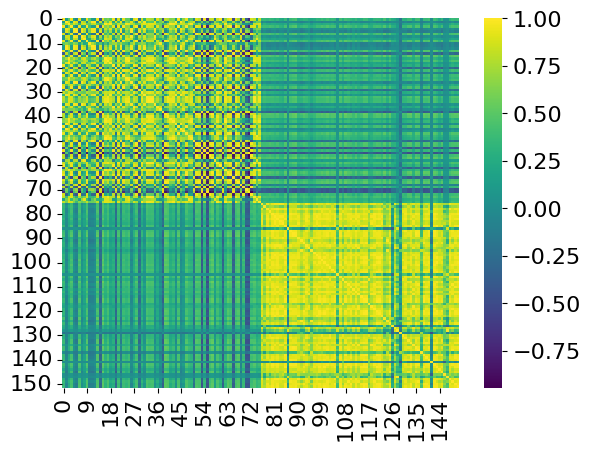

In [29]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp, euclidean_distance_df), cmap='viridis')

<Axes: >

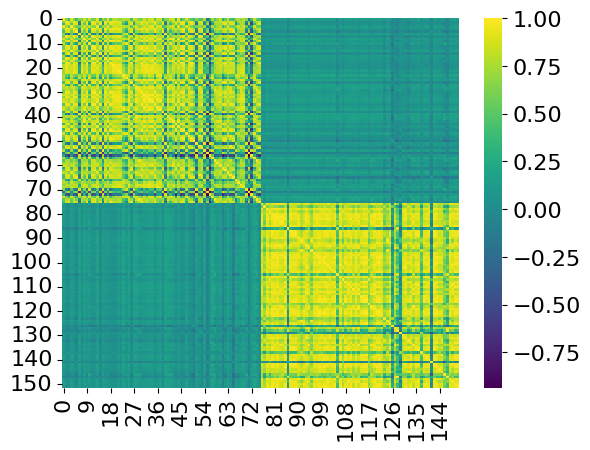

In [30]:
sns.heatmap(np.corrcoef(quantum_fidelity_matrix_amp_qft, euclidean_distance_df), cmap='viridis')

# statistical testing
- the proper test for 2 distance matrices is actually Mantel's test.
- we can use this if we have *distance* matrices to measure the correlation (-1 to +1)
- https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
- says spearman method should be use when non-linearity is expected, which we use here
- as implemented in skbio, mantel's test requires the diagonals to be 0
- this means that we should invert state fidelity (1-fidelity) bc the middle diagonal is 1, not 0
- The diagonal for state fidelity is not exactly 0, but it's very close to 0 so we can use Mantel's test anyways

In [31]:
from skbio.stats.distance import mantel, pwmantel
# wrapping to fill diagonals to 0
def mantel_test(a, b):
    # a and b should be PD dataframes
    a_np = a.to_numpy() if type(a) is pd.DataFrame else a
    b_np = b.to_numpy() if type(b) is pd.DataFrame else b
    np.fill_diagonal(a_np, 0)  # in-place ops
    np.fill_diagonal(b_np, 0)
    return mantel(a_np, b_np, method='spearman', seed=0)

def pw_mantel_test(dfs, labels=None):
    # a and b should be PD dataframes
    dfs_np = [d.to_numpy() if type(d) is pd.DataFrame else d.copy() for d in dfs]
    for d in dfs_np:
        np.fill_diagonal(d, 0)
    return pwmantel(dfs_np, method='spearman', labels=labels, seed=0)

In [32]:
# not the same
labels = [
    'Correlation',
        'Euclidean',
          'Angle',
          'Angle+IBM',
          'Amp',
          'Amp+IBM',
          'Amp+IBM+DDD',
          'Amp+QFT',
          'Amp+QFT+IBM',
          'Amp+QFT+IBM+DDD',
    ]
stat_result = pw_mantel_test(
    [
        corrs_df, # still works despite not being distances as we are comparing rank orders
        euclidean_distance_df,
        quantum_fidelity_matrix_ang,
        qpu_ang,
        quantum_fidelity_matrix_amp,
        qpu_amp,
        qpu_amd_ddd,
        quantum_fidelity_matrix_amp_qft,
        qpu_amp_qft,
        qpu_amp_qft_ddd,
        # euclidean_distance_ifft_df,
    ],
    labels=labels
)
# rank correlation shows how correlated the ranks of data are
# Euclidean is almost identical to EiFFT
stat_result_table = stat_result[['statistic', 'p-value']]
stat_result_table

statistic  p-value
dm1         dm2                                
Correlation Euclidean        -0.487926    0.001
            Angle            -0.032489    0.575
            Angle+IBM        -0.331655    0.001
            Amp               0.004966    0.904
            Amp+IBM          -0.333363    0.001
            Amp+IBM+DDD      -0.317744    0.001
            Amp+QFT          -0.015298    0.766
            Amp+QFT+IBM      -0.429649    0.001
            Amp+QFT+IBM+DDD  -0.426339    0.001
Euclidean   Angle             0.116311    0.147
            Angle+IBM         0.679722    0.001
            Amp               0.257543    0.001
            Amp+IBM           0.775658    0.001
            Amp+IBM+DDD       0.789896    0.001
            Amp+QFT           0.135725    0.101
            Amp+QFT+IBM       0.879634    0.001
            Amp+QFT+IBM+DDD   0.883580    0.001
Angle       Angle+IBM         0.081828    0.202
            Amp               0.210883    0.001
            Amp+IBM           0.133687    0.058
            Amp+IBM+DDD       0.142737    0.061
            Amp+QFT           0.281679    0.002
            Amp+QFT+IBM       0.104128    0.181
            Amp+QFT+IBM+DDD   0.109096    0.138
Angle+IBM   Amp               0.139204    0.016
            Amp+IBM           0.565428    0.001
            Amp+IBM+DDD       0.571826    0.001
            Amp+QFT           0.094281    0.127
            Amp+QFT+IBM       0.641650    0.001
            Amp+QFT+IBM+DDD   0.635859    0.001
Amp         Amp+IBM           0.262806    0.001
            Amp+IBM+DDD       0.285699    0.001
            Amp+QFT           0.510871    0.001
            Amp+QFT+IBM       0.228310    0.001
            Amp+QFT+IBM+DDD   0.251566    0.001
Amp+IBM     Amp+IBM+DDD       0.918820    0.001
            Amp+QFT           0.148971    0.029
            Amp+QFT+IBM       0.745468    0.001
            Amp+QFT+IBM+DDD   0.758349    0.001
Amp+IBM+DDD Amp+QFT           0.181668    0.018
            Amp+QFT+IBM       0.761468    0.001
            Amp+QFT+IBM+DDD   0.777172    0.001
Amp+QFT     Amp+QFT+IBM       0.165885    0.026
            Amp+QFT+IBM+DDD   0.171765    0.027
Amp+QFT+IBM Amp+QFT+IBM+DDD   0.904061    0.001

In [33]:
statistic_matrix = stat_result_table.reset_index().pivot_table(index='dm1', columns='dm2')['statistic']
# sort rows by number of NaNs
statistic_matrix = statistic_matrix.loc[statistic_matrix.isnull().sum(axis=1).sort_values(ascending=False).index]
# then sort columns
statistic_matrix = statistic_matrix[statistic_matrix.isnull().sum(axis=0).sort_values(ascending=False).index]
statistic_matrix

dm2,Euclidean,Angle,Angle+IBM,Amp,Amp+IBM,Amp+IBM+DDD,Amp+QFT,Amp+QFT+IBM,Amp+QFT+IBM+DDD
dm1,,,,,,,,,
Amp+QFT+IBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.904061
Amp+QFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165885,0.171765
Amp+IBM+DDD,NaN,NaN,NaN,NaN,NaN,NaN,0.181668,0.761468,0.777172
Amp+IBM,NaN,NaN,NaN,NaN,NaN,0.918820,0.148971,0.745468,0.758349
Amp,NaN,NaN,NaN,NaN,0.262806,0.285699,0.510871,0.228310,0.251566
Angle+IBM,NaN,NaN,NaN,0.139204,0.565428,0.571826,0.094281,0.641650,0.635859
Angle,NaN,NaN,0.081828,0.210883,0.133687,0.142737,0.281679,0.104128,0.109096
Euclidean,NaN,0.116311,0.679722,0.257543,0.775658,0.789896,0.135725,0.879634,0.883580
Correlation,-0.487926,-0.032489,-0.331655,0.004966,-0.333363,-0.317744,-0.015298,-0.429649,-0.426339


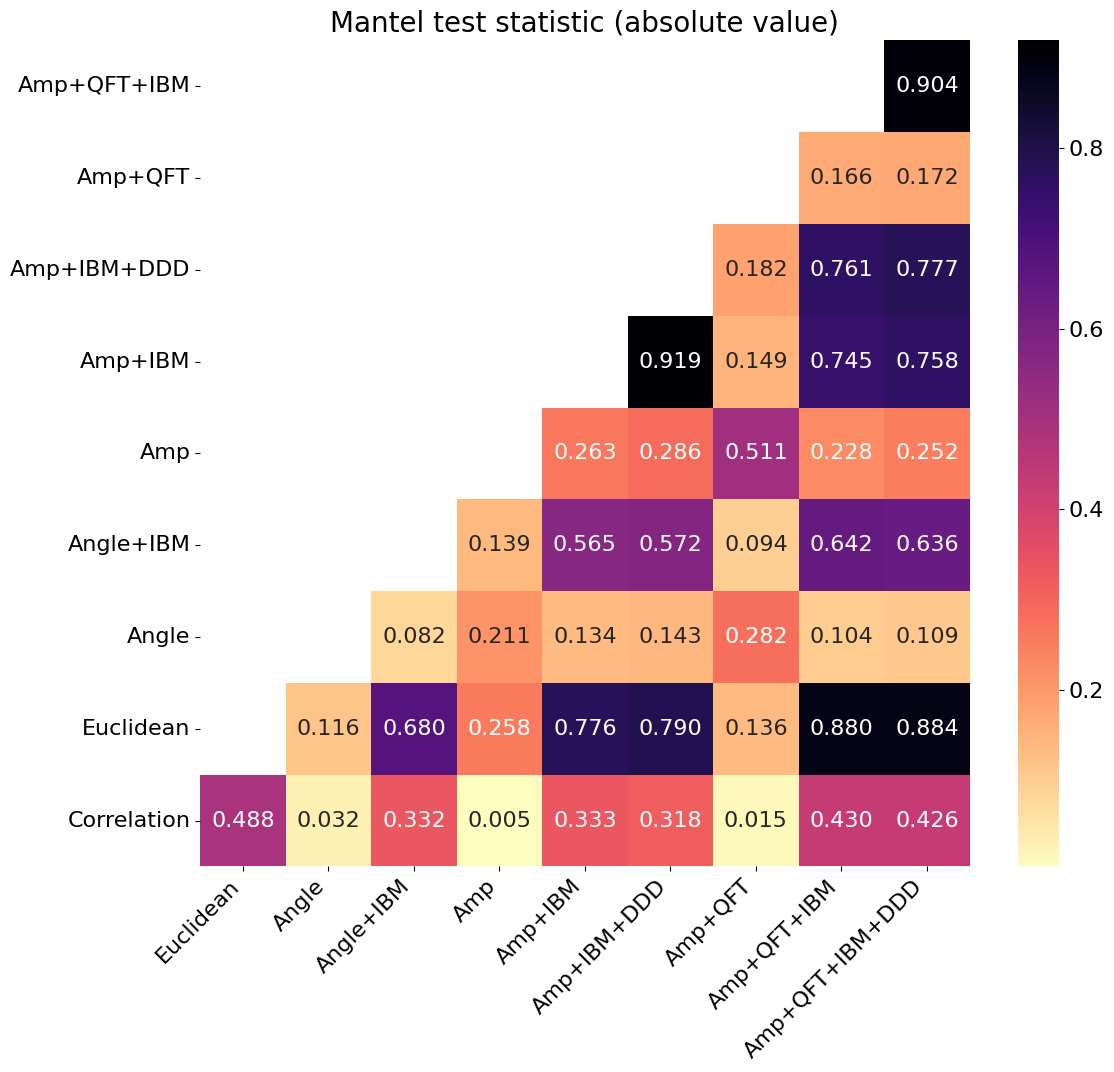

In [39]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(12, 11))
sns.heatmap(np.abs(statistic_matrix), annot=True, cmap='magma_r', fmt='.3f')
plt.title("Mantel test statistic (absolute value)", fontsize=20)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(ENV['PWD'] + '/figures/mantel-test.png', dpi=300)
plt.show()

In [35]:
pvalue_matrix = stat_result_table.reset_index().pivot_table(index='dm1', columns='dm2')['p-value']
# sort rows by number of NaNs
pvalue_matrix = pvalue_matrix.loc[pvalue_matrix.isnull().sum(axis=1).sort_values(ascending=False).index]
# then sort columns
pvalue_matrix = pvalue_matrix[pvalue_matrix.isnull().sum(axis=0).sort_values(ascending=False).index]
pvalue_matrix

dm2,Euclidean,Angle,Angle+IBM,Amp,Amp+IBM,Amp+IBM+DDD,Amp+QFT,Amp+QFT+IBM,Amp+QFT+IBM+DDD
dm1,,,,,,,,,
Amp+QFT+IBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001
Amp+QFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026,0.027
Amp+IBM+DDD,NaN,NaN,NaN,NaN,NaN,NaN,0.018,0.001,0.001
Amp+IBM,NaN,NaN,NaN,NaN,NaN,0.001,0.029,0.001,0.001
Amp,NaN,NaN,NaN,NaN,0.001,0.001,0.001,0.001,0.001
Angle+IBM,NaN,NaN,NaN,0.016,0.001,0.001,0.127,0.001,0.001
Angle,NaN,NaN,0.202,0.001,0.058,0.061,0.002,0.181,0.138
Euclidean,NaN,0.147,0.001,0.001,0.001,0.001,0.101,0.001,0.001
Correlation,0.001,0.575,0.001,0.904,0.001,0.001,0.766,0.001,0.001


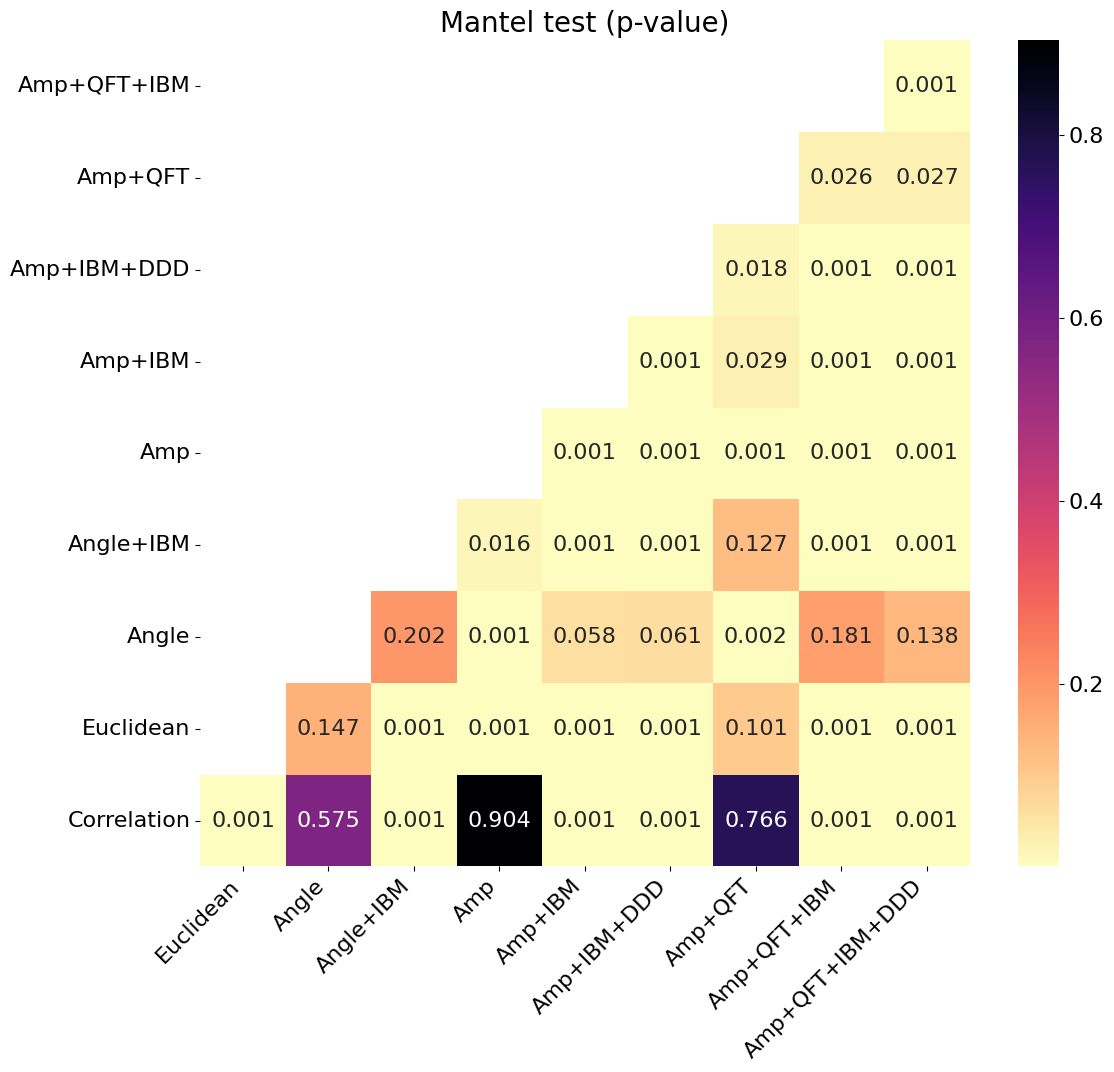

In [40]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(12, 11))

sns.heatmap(pvalue_matrix, annot=True, cmap='magma_r', fmt='.3f')
plt.plot(size=(12, 10))
plt.title("Mantel test (p-value)", fontsize=20)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(ENV['PWD'] + '/figures/mantel-test-pvalue.png', dpi=300)
plt.show()